Next steps:
1. Add a "master node" that connects all nodes together, so that message passing works between all nodes

In [1]:
import pandas as pd

from EmbedDataset import LigandBinaryDataset

import time
import numpy as np
import torch
from torch_geometric.loader import DataLoader

In [2]:
dataset = LigandBinaryDataset('./data2/')

In [3]:
dataset = dataset.shuffle()
train_dataset = dataset[:int(len(dataset) * 0.7)]
val_dataset = dataset[int(len(dataset) * 0.7):int(len(dataset) * 0.85)]
test_dataset = dataset[int(len(dataset) * 0.85):]

In [4]:
train_dl = DataLoader(train_dataset, batch_size=16)
val_dl = DataLoader(val_dataset, batch_size=16)
test_dl = DataLoader(test_dataset, batch_size=16)

In [6]:
from LigandGNNV2 import LigandGNNV2
from LigandGNNV1 import LigandGNNV1

device = torch.device('cuda')
# model = LigandGNNV1(dataset.num_node_features, 1).to(device)
model = LigandGNNV2(256, 28, dataset[0]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max')
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([20]).to(device))

In [7]:
def train(model, loader, criterion, optimizer):
    model.train()

    loss_acc = 0.
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y

        loss = criterion(output, label.reshape(-1, 1))
        loss.backward()
        loss_acc += data.num_graphs * loss.item()
        optimizer.step()

    return loss_acc / len(loader.dataset)

In [18]:
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc, precision_recall_fscore_support, roc_auc_score

def evaluate(model, loader):
    model.eval()

    preds = np.asarray([])
    labels = np.asarray([])

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = torch.sigmoid(model(data).round().squeeze().cpu()).round().numpy()
            label = data.y.cpu().numpy()

            preds = np.concatenate([preds, pred])
            labels = np.concatenate([labels, label])

    precision, recall, _ = precision_recall_curve(labels, preds)
    fpr, tpr, thresholds = roc_curve(labels, preds, pos_label=1)
    print(precision_recall_fscore_support(labels, preds))
    return auc(fpr, tpr), auc(recall, precision)
    return roc_auc_score(labels, preds)

In [9]:
train_hist = []
val_hist = []
for epoch in range(1, 201):
    s = time.time()
    loss = train(model, train_dl, criterion, optimizer)
    train_score = evaluate(model, train_dl)
    val_score = evaluate(model, val_dl)
    # scheduler.step(val_score)
    e = time.time()

    train_hist.append(train_score)
    val_hist.append(val_score)

    # print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score:.05f}, Val Score: {val_score:.05f}, Time: {e - s:.05f}s')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score}, Val Score: {val_score}, Time: {e - s:.05f}s')

Epoch: 001, Loss: 1.06089, Train Score: 0.6657322052986582, Val Score: 0.6696066198048812, Time: 17.79700s
Epoch: 002, Loss: 0.98178, Train Score: 0.6294986241623703, Val Score: 0.6214372542696863, Time: 14.82051s
Epoch: 003, Loss: 0.95383, Train Score: 0.6466449215829981, Val Score: 0.6391516248743443, Time: 16.24900s
Epoch: 004, Loss: 0.90650, Train Score: 0.6546034351939696, Val Score: 0.649754882777705, Time: 16.28047s
Epoch: 005, Loss: 0.87465, Train Score: 0.6439985120133592, Val Score: 0.644125840754905, Time: 15.36059s
Epoch: 006, Loss: 0.83713, Train Score: 0.6796469209138265, Val Score: 0.6843800458897844, Time: 16.10000s
Epoch: 007, Loss: 0.82072, Train Score: 0.6821095473126605, Val Score: 0.6835624766410383, Time: 14.81800s
Epoch: 008, Loss: 0.81081, Train Score: 0.7224193139131602, Val Score: 0.719454207937582, Time: 15.14600s
Epoch: 009, Loss: 0.75775, Train Score: 0.7550084699840923, Val Score: 0.7497260507190796, Time: 15.15600s
Epoch: 010, Loss: 0.73647, Train Score: 

KeyboardInterrupt: 

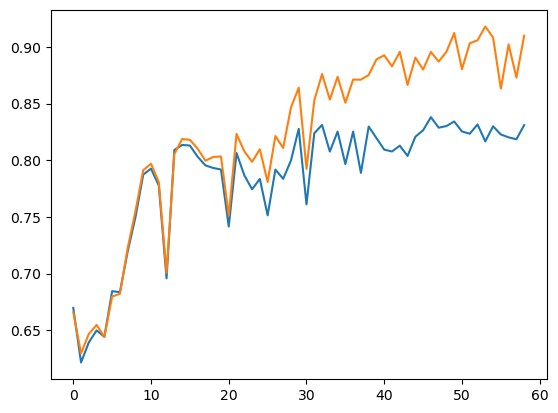

In [10]:
import matplotlib.pyplot as plt
plt.plot(val_hist)
plt.plot(train_hist)
plt.show()

In [19]:
evaluate(model, test_dl)

(array([0.97860893, 0.37138158]), array([0.96932535, 0.46100449]), array([0.97394502, 0.41136819]), array([62299,  2449], dtype=int64))


(0.7151649209779434, 0.42638640033432695)

In [12]:
data = test_dl.dataset[9].to(device)

In [13]:
pred = model(data)

In [14]:
out = torch.sigmoid(pred).round()
out

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [15]:
print(out.sum())
print(len(out))

tensor(55., device='cuda:0', grad_fn=<SumBackward0>)
267


In [16]:
len(data.y) / data.y.sum()

tensor(5.9333, device='cuda:0')

In [17]:
data.y.sum()

tensor(45., device='cuda:0')

In [ ]:
f1_score(data.y.detach().cpu().numpy(), out.detach().cpu().numpy())